In [86]:
#import amaozn data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

# Data cleaning

In [87]:
#read data with decimals as dot
df = pd.read_csv('../../data/amazon_search_hedonic.csv', sep = ";", decimal = ".")

In [88]:
#remove duplicates and empty variables
df1 = len(df)
df = df.drop_duplicates(subset = ['review_title', 'review', 'date', 'name', 'profile_url'])
df2 = len(df)
print('Removed', df1 - df2, 'duplicates')
df = df[df['country'] == 'the United States']
df = df[df['review'] != '']
#remove reviews with na
df = df.dropna(subset = ['review'])
df3 = len(df)
print('Removed', df2 - df3, 'empty reviews')


Removed 32406 duplicates
Removed 12407 empty reviews


In [89]:
# correct mistake in encoding numerical data
df['helpful'] = df['helpful'].str.replace(',', '')

df['helpful'] = pd.to_numeric(df['helpful'])

In [90]:
#impute 0 for missing helpful votes
df['helpful'] = df['helpful'].fillna(0)

In [91]:
#merge with category data
def remove_last_digit(string):
    return re.sub(r'\d+$', '', string)

df['asin_url_clean'] = df['asin_url'].apply(remove_last_digit)
links_data = pd.read_csv(f"../../gen/input/amazon_links_per_category.csv", delimiter = ";")
#remove duplicates for links_data product_link
links_data = links_data.drop_duplicates(subset = ['product_link'])
df = pd.merge(df, links_data, left_on = 'asin_url_clean', right_on = 'product_link', how = 'left')

In [92]:
df.columns

Index(['asin_url', 'brand', 'model', 'link', 'product_title', 'name_x',
       'rating', 'review_title', 'country', 'date', 'specs', 'first_spec',
       'review', 'helpful', 'picture', 'verified', 'profile', 'video',
       'scrape_date', 'profile_url', 'asin_url_clean', 'name_y', 'asin',
       'product_link', 'page_link', 'category'],
      dtype='object')

In [93]:
#drop columns
df = df.drop(columns = ['brand', 'model', 'first_spec', 'asin_url_clean', 'product_link', 'page_link', 'name_y'])

In [94]:
#summary
print(df['category'].value_counts())

mascara                 12200
microwave oven          10868
vacuum cleaner          10723
Digital Photo Frames    10657
razor                   10593
computer adapter        10092
lipstick                 9924
electric toothbrush      9711
party dress              9434
dvd_player               9275
printer                  9212
smartphone               8890
Name: category, dtype: int64


# Add variables

In [95]:
import ast
def count_photos(pics):
    if pics == 'no':
        return 0
    else:
        return len(ast.literal_eval(pics))

df['n_pictures'] = df['picture'].apply(count_photos)

In [96]:
#length of review
df['review_len'] = df['review'].str.len()

In [97]:
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')

In [98]:
df['days_diff'] = (pd.to_datetime(df['scrape_date']) - df['date']).dt.days

In [104]:
#print the number of observations per category, and the number of unique products, and the number of non=nan profile values
df_descriptives = df.groupby('category').agg({'category': 'size',
                                  'asin': 'nunique',
                                  'profile': lambda x: sum(~x.isna()),
                                  'picture': lambda x: sum(x != 'no'),
                                  'n_pictures': 'mean',
                                  'review_len' : 'mean',
                                  'helpful' : 'mean',
                                    'rating' : 'mean',
                                    #add average date
                                    'days_diff' : 'mean'

                                  })
#df_descriptives.columns = ['n_obs', 'n_products', 'n_profiles', 'n_pictures', 'photos_per_review', 'helpful_mean', 'rating_mean']
df_descriptives['profile'] = df_descriptives['profile']/df_descriptives['category']*100
df_descriptives['picture'] = df_descriptives['picture']/df_descriptives['category']*100

#change order of category
df_descriptives = df_descriptives.reindex(df['category'].unique())
#add average at bottom
df_descriptives.loc['average'] = df_descriptives.mean()
#sum at the bottom, except for the average row
df_descriptives.loc['sum'] = df_descriptives.iloc[:-1, :].sum()
#round values to 3 decimals
df_descriptives = df_descriptives.round(2)
#to percentage
df_descriptives['profile'] = df_descriptives['profile'].astype(str) + '%'
df_descriptives['picture'] = df_descriptives['picture'].astype(str) + '%'
print(df_descriptives)
#save to excel
df_descriptives.to_excel('../../gen/output/amazon_descriptives.xlsx')

                       category    asin  profile  picture  n_pictures  \
category                                                                
dvd_player              9275.00   146.0   14.91%    4.18%        0.10   
Digital Photo Frames   10657.00   206.0   21.11%   12.59%        0.31   
smartphone              8890.00   338.0   18.08%    7.63%        0.19   
computer adapter       10092.00   246.0   18.25%    5.13%        0.10   
printer                 9212.00   177.0   15.61%    5.91%        0.11   
electric toothbrush     9711.00   165.0    21.3%    8.62%        0.21   
mascara                12200.00   142.0   17.39%     5.8%        0.10   
lipstick                9924.00   156.0   20.61%    9.89%        0.17   
party dress             9434.00   182.0    23.2%   31.42%        0.52   
microwave oven         10868.00   170.0   14.24%    9.09%        0.17   
vacuum cleaner         10723.00   224.0   15.15%    8.48%        0.20   
razor                  10593.00   140.0   19.14%   

In [103]:
df_descriptives.iloc[:-1, :]

,category,asin,profile,picture,n_pictures,review_len,helpful,rating,days_diff
category,,,,,,,,,
dvd_player,9275.00,146.0,14.91%,4.18%,0.10,397.45,4.62,3.88,1591.21
Digital Photo Frames,10657.00,206.0,21.11%,12.59%,0.31,435.78,2.09,4.29,437.34
smartphone,8890.00,338.0,18.08%,7.63%,0.19,470.83,4.71,3.64,545.22
computer adapter,10092.00,246.0,18.25%,5.13%,0.10,235.76,0.76,4.29,734.91
printer,9212.00,177.0,15.61%,5.91%,0.11,631.21,7.90,3.74,1343.99
electric toothbrush,9711.00,165.0,21.3%,8.62%,0.21,334.57,1.97,4.22,391.89
mascara,12200.00,142.0,17.39%,5.8%,0.10,250.93,2.65,4.11,530.16
lipstick,9924.00,156.0,20.61%,9.89%,0.17,190.95,1.79,4.02,654.96
party dress,9434.00,182.0,23.2%,31.42%,0.52,221.00,3.45,4.29,271.33


In [15]:
df.columns

Index(['asin_url', 'link', 'product_title', 'name_x', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'asin', 'category',
       'n_pictures', 'review_len', 'days_diff'],
      dtype='object')

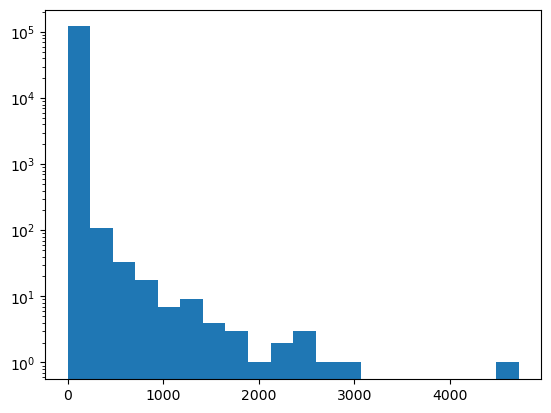

In [16]:
#show histogram of helpful votes with log10 y scale

plt.hist(df['helpful'], bins = 20)
plt.yscale('log')

In [17]:
#proportion of reviews with at least 1 helpful vote
len(df[df['helpful'] > 0]) / len(df)

0.46679113991725546

# review cleaning

In [18]:
#remove punctuation from review
print(df['review'][0])
df['review_clean'] = df['review'].str.replace('[^\w\s]','')
print(df['review_clean'][0])
#lowercase everything
df['review_clean'] = df['review_clean'].str.lower()
print(df['review_clean'][0])
#remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df['review_clean'][0])
#stemming
from nltk.stem import PorterStemmer
porter = PorterStemmer()
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))
print(df['review_clean'][0])
#tokenize review
#from nltk.tokenize import word_tokenize
#df['review_clean'] = df['review_clean'].apply(word_tokenize)
#print(df['review_clean'][0])


This brand DVD player works great.  Will be buying several more for MBR, guest room, and craft room.


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\2016550727.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_clean'] = df['review'].str.replace('[^\w\s]','')


This brand DVD player works great  Will be buying several more for MBR guest room and craft room
this brand dvd player works great  will be buying several more for mbr guest room and craft room
brand dvd player works great buying several mbr guest room craft room
brand dvd player work great buy sever mbr guest room craft room


In [82]:
#save to csv
df.to_csv('../../gen/input/amazon_search_hedonic_clean.csv', sep = ";", index = False)

In [26]:
print(df['review'][0])
print('-----------------------')
print(df['review_clean'][0])

This brand DVD player works great.  Will be buying several more for MBR, guest room, and craft room.
-----------------------
brand dvd player work great buy sever mbr guest room craft room


# Baseline test

In [105]:
#open csv
df = pd.read_csv('../../gen/input/amazon_search_hedonic_clean.csv', sep = ";")

In [84]:
df['days_diff'].describe()

count    114978.000000
mean        659.717416
std         962.037709
min           0.000000
25%          80.000000
50%         253.000000
75%         821.000000
max        8060.000000
Name: days_diff, dtype: float64

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor


vectorizer = CountVectorizer(max_features = 1000)

In [33]:
df[df['review_clean'].isna()][['review_clean', 'review']]

,review_clean,review
375,NaN,A
1056,NaN,A
1772,NaN,So so
2263,NaN,A+
2316,NaN,It does what it should.
...,...,...
116980,NaN,A+
118027,NaN,Above
118701,NaN,A+
121122,NaN,on


In [107]:
#split data
df = df.dropna(subset = ['review_clean'])

In [108]:
#remove outliers with percentile
df = df[df['helpful'] < df['helpful'].quantile(0.95)]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['helpful'], test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#fit vectorizer
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [75]:
from sklearn.feature_selection import SelectKBest, f_regression

# Initialize SelectKBest with f_regression
kbest = SelectKBest(f_regression, k=1000)

# Perform feature selection
X_train_k = kbest.fit_transform(X_train, y_train)
X_val_k = kbest.transform(X_val)
X_test_k = kbest.transform(X_test)

In [76]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_k, y_train)

KNeighborsRegressor()

In [77]:
y_pred = knn.predict(X_val_k)

In [78]:
#mse
mse = (y_pred - y_val)**2

In [79]:
#get top 10 largest values in mse
mse.nlargest(10)

36565     121.0
27614     121.0
61719     121.0
88488     121.0
19467     121.0
49100     121.0
30591     121.0
100877    121.0
64625     121.0
71384     121.0
Name: helpful, dtype: float64

In [80]:
np.mean(mse)

4.917543849476705

In [72]:
#do a grid search
from sklearn.neighbors import KNeighborsRegressor

#results df
#results = pd.DataFrame(columns = ['k', 'mse'])
for k in range(15, 25, 2):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print(k, np.mean((y_pred - y_val)**2))
    results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)

15 4.880813433965668


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


17 4.875604467964364


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


19 4.872842641081859


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


21 4.874354670404387


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


23 4.877224917885589


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


In [74]:
#sve
results.to_csv('../../gen/output/amazon_knn_results.csv', index = False)

In [75]:
#import packages
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor


featurizer = ColumnTransformer(
transformers=[
("review_clean", TfidfVectorizer(max_features= 1000), "review_clean")
],
remainder='drop')

#model
model = Pipeline([
('features', featurizer),
#('scaler', MaxAbsScaler()),
('knn', KNeighborsRegressor(n_neighbors=5))
])

#split data
X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['helpful'], test_size=0.33, random_state=42)

#fit model
model.fit(X_train, y_train)
#predict
y_pred = model.predict(X_test)

#accuracy
accuracy_score(y_test, y_pred)

IndexError: tuple index out of range

# Random forest